In [1]:
# from sympy import *
import matplotlib.pyplot as plt

import sympy as sp
from sympy.plotting import plot, plot3d, plot3d_parametric_line, plot3d_parametric_surface

import symengine as se
#from symengine import *

sp.init_printing()
from interval import interval
from interval import imath
import sys
from pprint import pprint

import numpy as np
import pandas as pd

from ivmat import ivmat, fmat, Krawczyk

In [2]:
import sys
sys.setrecursionlimit(100000)

import time

In [4]:
_X_num= 20
_X_dim =  2
_X = se.symbols('x1:%d' % (_X_num * _X_dim + 1))
theta = l, sigma_f, sigma_n = se.symbols('l sigma_f sigma_n')

#data_df = pd.read_pickle('dump/data_df.pkl').sample(n=2, random_state=921)
data_df = pd.read_pickle('dump/data_df.pkl').sample(n=5)
display(data_df)
X = np.array(list(data_df.X))
y = np.array(data_df.y)
print(X.shape, y.shape)

,X,y
41,"[-2.58038102647, 12.4829440005]",4.098547
42,"[6.28314885084, 14.699170644]",204.808842
93,"[-1.775574922, 5.97714091584]",18.503963
91,"[-3.10405068799, 3.76115292675]",71.483509
97,"[8.55338539981, 12.1863471629]",110.787023


((5, 2), (5,))


In [5]:
def kernel(p, q, i, j):
    """
    p,q: np.array
    """
    def rbf(p, q):        
        dist = np.sum((p - q) ** 2)
        return se.exp(-(1. / l**2) * dist)
    
    ans =  (sigma_f**2) * rbf(p, q) + (sigma_n**2) * int(i == j) # 対角成分のみnoiseを追加
    return ans


In [6]:
K = se.Matrix([[kernel(p, q, i, j) for j,q in enumerate(X)] for i,p in enumerate(X)])
print(len(y))
if len(y) < 5:
    display(K)

5


## fを定義
- $f(\theta)$を最小化

In [7]:
y = se.Matrix(y)

def get_log_prob_expr(K, y): 
    K_inv = K.inv('LU')
    first_tem = (1/2.) * (y.T)*(K_inv)*(y)
    second_term = (1/2.) * se.Matrix([se.log(K.det())])
    third_term = se.Matrix([(len(y)/2.) * se.log(2*se.pi)])
    log_prob = - first_tem -  second_term - third_term
    return log_prob[0, 0]


log_prob_expr = get_log_prob_expr(K, y)
f_expr = - log_prob_expr

In [8]:
g_expr = f_expr.subs(sigma_f, 3)
g = se.lambdify((l, sigma_n), [g_expr])

In [9]:
l_min, l_max = (0.5, 5.)
sigma_n_min, sigma_n_max = (0.1, 5.)

GRID_NUM = 60
l_interval = (l_max - l_min)/ GRID_NUM * 1.0
sigma_n_interval = (sigma_n_max - sigma_n_min)/ GRID_NUM * 1.0


#fig = plot3d(g_expr, (l, l_min, l_max), (sigma_n, sigma_n_min, sigma_n_max))

x = np.arange(l_min, l_max, l_interval) # length scale
y = np.arange(sigma_n_min, sigma_n_max, sigma_n_interval) # noise 
X, Y =  np.meshgrid(x, y)
Z = np.array([g(*x) for x in np.array([X.flatten(), Y.flatten()]).T ]).reshape(X.shape)

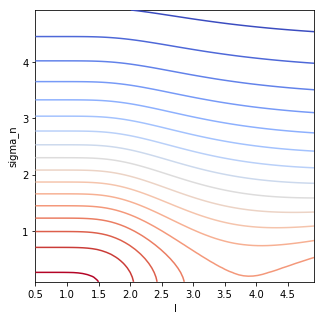

In [10]:

plt.figure(figsize=(5,5))
# plt.xscale('log')
# plt.yscale('log')
plt.contour(X, Y, Z, 20, zorder=1000, shading='gouraud', cmap=plt.cm.coolwarm)
plt.xlabel('l')
plt.ylabel('sigma_n')
plt.show()

In [ ]:
st = time.time()

f = sp.lambdify(theta, f_expr, modules=(imath))

print time.time() - st

15.5469880104


In [ ]:
st = time.time()

df_expr = [[f_expr.diff(_theta)] for _theta in theta]
print time.time() - st


df = []
for row_expr in df_expr:
    tmp = []
    for _df_expr in row_expr:
        res = sp.lambdify(theta, _df_expr, modules=(imath))
        tmp.append(res)
    df.append(tmp)
df = fmat(df)

print(type(df))
print time.time() - st

0.852082014084


In [ ]:
st = time.time()

ddf_expr = []
for _df_expr in map(lambda x: x[0], df_expr):
    tmp_row = []
    for _theta in theta:
        tmp = _df_expr.diff(_theta)
        tmp_row.append(tmp)
    ddf_expr.append(tmp_row)

print time.time() - st
    
ddf = []    
for row in ddf_expr:
    tmp_row = []
    for _ddf_expr in row:
        tmp = sp.lambdify(theta, _ddf_expr, modules=(imath))
        tmp_row.append(tmp)
    ddf.append(tmp_row)
ddf = fmat(ddf)

print time.time() - st

In [ ]:
X = ivmat(
    [
        [interval[1.7, 2.3]], # l
        [interval[4.98, 5.02]], # sigma_f 
        [interval[0.01, 2.4]], # sigma_n
    ])

st = time.time()
df.apply_args(X)
print time.time() - st


st = time.time()
ddf.apply_args(X)
print time.time() - st


In [ ]:
X = ivmat(
    [
        [interval[1.7, 2.3]], # l
        [interval[2.98, 5.02]], # sigma_f 
        [interval[0.01, 2.4]], # sigma_n
    ])


print(X.shape)
kra = Krawczyk(df, ddf ,X)

st = time.time()

cnt_max = 100
max_width = 1e-6
ans_boxes, s_num_list, t_num_list, u_num_list, animation_boxes = kra.find_all_solution(trace=False, cnt_max=cnt_max, max_width=max_width)

print time.time() - st

In [ ]:
# import pickle

# def save_pickle(obj, path):
#     with open(path, 'wb') as f:
#         pickle.dump(obj, f)

# def load_pickle(path):
#     with open(path, 'rb') as f:
#         return pickle.load(f)
    

# save_pickle(f, 'dump/tmp_f')    
# save_pickle(df, 'dump/tmp_df')    
# save_pickle(ddf, 'dump/tmp_ddf')
